In [1]:
from sklearn.model_selection import GroupKFold, StratifiedKFold, KFold

from sklearn.dummy import DummyClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
from category_encoders import TargetEncoder
from sqlalchemy.dialects.mssql.information_schema import columns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import resample
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

from pandas.errors import PerformanceWarning
warnings.filterwarnings("ignore", category=PerformanceWarning)




/home/saatarko/anaconda3/envs/myenv/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
LAGS = [1, 2, 3]           # лаги
DIFFS = [1, 2]             # разности
ROLL_WINDOWS = [3, 5, 7]   # скользящие окна
EWMS = [0.3, 0.5, 0.7]     # экспоненциальные веса

def add_lags(df, cols, lags=[1,2,3], prefix="lag"):
    for c in cols:
        for l in lags:
            new_name = f"{c}_{prefix}{l}"
            if new_name not in df.columns:
                df[new_name] = df.groupby(["g1","g2"])[c].shift(l)
    return df

def add_diff(df, cols, lags=[1,2]):
    for c in cols:
        for l in lags:
            new_name = f"{c}_diff{l}"
            if new_name not in df.columns:
                df[new_name] = df.groupby(["g1","g2"])[c].diff(l)
    return df

def add_rollings(df, cols, windows=[3,5,7], prefix="roll"):
    for c in cols:
        for w in windows:
            new_name = f"{c}_{prefix}{w}"
            if new_name not in df.columns:
                df[new_name] = df.groupby(["g1","g2"])[c].shift(1).rolling(w).mean()
    return df

def add_ewm(df, cols, alphas=[0.3,0.5,0.7], prefix="ewm"):
    for c in cols:
        for alpha in alphas:
            new_name = f"{c}_{prefix}{int(alpha*10)}"
            if new_name not in df.columns:
                df[new_name] = df.groupby(["g1","g2"])[c].shift(1).ewm(alpha=alpha).mean()
    return df

def add_cumsum(df, cols, prefix="cumsum"):
    for c in cols:
        new_name = f"{c}_{prefix}"
        if new_name not in df.columns:
            df[new_name] = df.groupby(["g1","g2"])[c].cumsum()
    return df


In [3]:
df_train = pd.read_csv('train.csv', index_col='index')

In [4]:
df_test_base = pd.read_csv('test.csv')

In [5]:
df_train


,id,g1,g2,relative_date_number,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
index,,,,,,,,,,,,,,,,,
70,1705.0;13221.0;1.0,1705,13221,1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.0
71,1705.0;13221.0;2.0,1705,13221,2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.0
72,1705.0;13221.0;3.0,1705,13221,3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.0
73,1705.0;13221.0;4.0,1705,13221,4,0.0,0.0,0.0,0.0,0.000001,0.000005,0.000016,0.000008,4.501503e-07,0.0,0.000003,0.000094,1.0
74,1705.0;13221.0;5.0,1705,13221,5,0.0,0.0,0.0,0.0,0.000003,0.000005,0.000047,0.000025,4.051353e-06,0.0,0.000003,0.000071,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654215,697.0;17221.0;31.0,697,17221,31,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.0
654216,697.0;17221.0;32.0,697,17221,32,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.0
654217,697.0;17221.0;33.0,697,17221,33,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.0


In [5]:
df_train.head(36)

,id,g1,g2,relative_date_number,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
index,,,,,,,,,,,,,,,,,
70,1705.0;13221.0;1.0,1705,13221,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0
71,1705.0;13221.0;2.0,1705,13221,2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0
72,1705.0;13221.0;3.0,1705,13221,3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0
73,1705.0;13221.0;4.0,1705,13221,4,0.0,0.000000,0.000000,0.000000,0.000001,4.502395e-06,0.000016,0.000008,4.501503e-07,0.000000,2.636783e-06,0.000094,1.0
74,1705.0;13221.0;5.0,1705,13221,5,0.0,0.000000,0.000000,0.000000,0.000003,4.502395e-06,0.000047,0.000025,4.051353e-06,0.000000,2.514142e-06,0.000071,1.0
75,1705.0;13221.0;6.0,1705,13221,6,0.0,0.000000,0.000000,0.000000,0.000000,6.303353e-06,0.000000,0.000000,0.000000e+00,0.000000,4.169796e-06,0.000235,1.0
76,1705.0;13221.0;7.0,1705,13221,7,0.0,0.000000,0.000000,0.000000,0.000001,5.402874e-06,0.000000,0.000000,0.000000e+00,0.000000,9.504683e-06,0.000235,1.0
77,1705.0;13221.0;8.0,1705,13221,8,0.0,0.000000,0.000000,0.000000,0.000000,1.800958e-06,0.000000,0.000000,0.000000e+00,0.000000,1.250939e-05,0.000212,1.0
78,1705.0;13221.0;9.0,1705,13221,9,0.0,0.000000,0.000000,0.000000,0.000007,9.905269e-06,0.000000,0.000000,0.000000e+00,0.000000,1.514617e-05,0.000212,1.0


In [6]:
df_test_base

,id,g1,g2,relative_date_number,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
0,1757.0;16543.0;1.0,1757,16543,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,1757.0;16543.0;2.0,1757,16543,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,1757.0;16543.0;3.0,1757,16543,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,1757.0;16543.0;4.0,1757,16543,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,1757.0;16543.0;5.0,1757,16543,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262600,1145.0;8996.0;31.0,1145,8996,31,0.000073,0.000027,0.000557,0.000325,0.000358,0.000593,0.000797,0.000979,0.000715,0.000773,0.000259,1.0
262601,1145.0;8996.0;32.0,1145,8996,32,0.000082,0.000027,0.000557,0.000320,0.000346,0.000828,0.000994,0.001415,0.000458,0.000877,0.000282,1.0
262602,1145.0;8996.0;33.0,1145,8996,33,0.000033,0.000010,0.000248,0.000302,0.000332,0.000921,0.000739,0.001917,0.000257,0.000869,0.000400,1.0
262603,1145.0;8996.0;34.0,1145,8996,34,0.000073,0.000026,0.000557,0.000412,0.000448,0.000906,0.001174,0.001718,0.000486,0.001049,0.000400,1.0


In [7]:
df_train.describe()

,g1,g2,relative_date_number,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
count,391650.000000,391650.000000,391650.000000,391650.000000,391650.000000,391650.000000,391650.000000,391650.000000,391650.000000,391650.000000,391650.000000,3.916500e+05,391650.000000,391650.000000,391650.000000,391650.000000
mean,947.069526,9454.379893,18.000000,0.046393,0.000313,0.000605,0.001052,0.001322,0.001598,0.001494,0.001608,9.665011e-04,0.001083,0.002054,0.001712,0.718861
std,500.262220,5366.549883,10.099518,0.210336,0.008093,0.008962,0.007231,0.012258,0.013716,0.011622,0.012318,8.540218e-03,0.007732,0.016153,0.013391,0.449556
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,562.000000,4909.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,970.000000,9320.500000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000007,0.000012,0.000000,0.000008,9.003007e-07,0.000000,0.000019,0.000071,1.000000
75%,1372.000000,14102.000000,27.000000,0.000000,0.000020,0.000017,0.000155,0.000123,0.000185,0.000156,0.000172,8.507841e-05,0.000143,0.000244,0.000424,1.000000
max,1822.000000,18692.000000,35.000000,1.000000,1.000000,1.000000,0.894957,1.000000,1.000000,1.000000,1.000000,1.000000e+00,0.743992,1.000000,1.000000,1.000000


In [25]:
temp_df = df_train[(np.isclose(df_train["x12"], 1))]

In [26]:
temp_df

,id,g1,g2,relative_date_number,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
index,,,,,,,,,,,,,,,,,
73,1705.0;13221.0;4.0,1705,13221,4,0.0,0.0,0.0,0.0,0.000001,0.000005,0.000016,0.000008,4.501503e-07,0.0,2.636783e-06,0.000094,1.0
74,1705.0;13221.0;5.0,1705,13221,5,0.0,0.0,0.0,0.0,0.000003,0.000005,0.000047,0.000025,4.051353e-06,0.0,2.514142e-06,0.000071,1.0
75,1705.0;13221.0;6.0,1705,13221,6,0.0,0.0,0.0,0.0,0.000000,0.000006,0.000000,0.000000,0.000000e+00,0.0,4.169796e-06,0.000235,1.0
76,1705.0;13221.0;7.0,1705,13221,7,0.0,0.0,0.0,0.0,0.000001,0.000005,0.000000,0.000000,0.000000e+00,0.0,9.504683e-06,0.000235,1.0
77,1705.0;13221.0;8.0,1705,13221,8,0.0,0.0,0.0,0.0,0.000000,0.000002,0.000000,0.000000,0.000000e+00,0.0,1.250939e-05,0.000212,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654092,1486.0;14128.0;13.0,1486,14128,13,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,1.839616e-07,0.000024,1.0
654093,1486.0;14128.0;14.0,1486,14128,14,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,4.292437e-07,0.000024,1.0
654094,1486.0;14128.0;15.0,1486,14128,15,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,4.292437e-07,0.000024,1.0


In [12]:
temp_df = df_train[df_train["y"] == 1]

In [14]:
temp_df

,id,g1,g2,relative_date_number,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
index,,,,,,,,,,,,,,,,,
632,1014.0;5457.0;3.0,1014,5457,3,1.0,0.000000,0.000000,0.000000,0.000041,0.000032,0.000031,0.000041,0.000009,0.000000,0.000186,0.000212,1.0
633,1014.0;5457.0;4.0,1014,5457,4,1.0,0.000020,0.000003,0.000124,0.000044,0.000044,0.000078,0.000082,0.000012,0.000114,0.000200,0.000330,1.0
634,1014.0;5457.0;5.0,1014,5457,5,1.0,0.000004,0.000002,0.000031,0.000022,0.000019,0.000000,0.000016,0.000001,0.000057,0.000162,0.000188,1.0
635,1014.0;5457.0;6.0,1014,5457,6,1.0,0.000000,0.000000,0.000000,0.000039,0.000052,0.000031,0.000016,0.000005,0.000000,0.000143,0.000212,1.0
636,1014.0;5457.0;7.0,1014,5457,7,1.0,0.000008,0.000001,0.000062,0.000033,0.000065,0.000047,0.000049,0.000011,0.000086,0.000093,0.000282,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653654,1583.0;10282.0;30.0,1583,10282,30,1.0,0.000151,0.000104,0.001115,0.000914,0.000701,0.000968,0.001018,0.001226,0.001259,0.001699,0.002024,1.0
653655,1583.0;10282.0;31.0,1583,10282,31,1.0,0.000163,0.000078,0.001176,0.000882,0.000720,0.001109,0.001010,0.001284,0.001087,0.001507,0.002071,1.0
653656,1583.0;10282.0;32.0,1583,10282,32,1.0,0.000110,0.000058,0.000805,0.000839,0.000661,0.001062,0.000969,0.001736,0.001144,0.001392,0.002377,1.0


In [15]:
temp_df.describe()

,g1,g2,relative_date_number,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
count,18170.000000,18170.000000,18170.000000,18170.0,18170.000000,18170.000000,18170.000000,18170.000000,18170.000000,18170.000000,18170.000000,18170.000000,18170.000000,18170.000000,18170.000000,1.817000e+04
mean,900.906879,8822.088993,19.321849,1.0,0.000394,0.001466,0.001876,0.002482,0.002947,0.002266,0.002762,0.001175,0.002003,0.003431,0.001607,1.000000e+00
std,482.082689,4784.568207,9.988049,0.0,0.004097,0.017975,0.012271,0.017036,0.019888,0.016626,0.020286,0.006617,0.014150,0.021755,0.007818,4.001354e-13
min,4.000000,3.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000024,1.000000e+00
25%,539.000000,5193.000000,9.000000,1.0,0.000000,0.000000,0.000000,0.000004,0.000007,0.000000,0.000000,0.000000,0.000000,0.000018,0.000047,1.000000e+00
50%,989.000000,8964.000000,19.000000,1.0,0.000004,0.000002,0.000031,0.000039,0.000055,0.000031,0.000041,0.000019,0.000029,0.000089,0.000141,1.000000e+00
75%,1293.000000,12776.000000,29.000000,1.0,0.000073,0.000076,0.000495,0.000459,0.000631,0.000484,0.000583,0.000287,0.000486,0.000883,0.000683,1.000000e+00
max,1783.000000,18623.000000,35.000000,1.0,0.222755,1.000000,0.564348,0.579803,0.733197,0.865890,1.000000,0.252429,0.743992,0.903571,0.188777,1.000000e+00


In [22]:
df_train[df_train["y"] == 1]["x12"].value_counts()

x12
1.0    18170
Name: count, dtype: int64

In [16]:
temp_df = df_train[(df_train["y"] == 1) & (np.isclose(df_train["x12"], 1))]

In [17]:
temp_df

,id,g1,g2,relative_date_number,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
index,,,,,,,,,,,,,,,,,
632,1014.0;5457.0;3.0,1014,5457,3,1.0,0.000000,0.000000,0.000000,0.000041,0.000032,0.000031,0.000041,0.000009,0.000000,0.000186,0.000212,1.0
633,1014.0;5457.0;4.0,1014,5457,4,1.0,0.000020,0.000003,0.000124,0.000044,0.000044,0.000078,0.000082,0.000012,0.000114,0.000200,0.000330,1.0
634,1014.0;5457.0;5.0,1014,5457,5,1.0,0.000004,0.000002,0.000031,0.000022,0.000019,0.000000,0.000016,0.000001,0.000057,0.000162,0.000188,1.0
635,1014.0;5457.0;6.0,1014,5457,6,1.0,0.000000,0.000000,0.000000,0.000039,0.000052,0.000031,0.000016,0.000005,0.000000,0.000143,0.000212,1.0
636,1014.0;5457.0;7.0,1014,5457,7,1.0,0.000008,0.000001,0.000062,0.000033,0.000065,0.000047,0.000049,0.000011,0.000086,0.000093,0.000282,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653654,1583.0;10282.0;30.0,1583,10282,30,1.0,0.000151,0.000104,0.001115,0.000914,0.000701,0.000968,0.001018,0.001226,0.001259,0.001699,0.002024,1.0
653655,1583.0;10282.0;31.0,1583,10282,31,1.0,0.000163,0.000078,0.001176,0.000882,0.000720,0.001109,0.001010,0.001284,0.001087,0.001507,0.002071,1.0
653656,1583.0;10282.0;32.0,1583,10282,32,1.0,0.000110,0.000058,0.000805,0.000839,0.000661,0.001062,0.000969,0.001736,0.001144,0.001392,0.002377,1.0


In [21]:
df_train["x12"].value_counts()

x12
1.0    281542
0.0    110108
Name: count, dtype: int64

In [18]:
temp_df = df_train[(df_train["y"] == 1) & (np.isclose(df_train["x12"], 0))]

In [19]:
temp_df

,id,g1,g2,relative_date_number,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
index,,,,,,,,,,,,,,,,,


In [12]:
pd.crosstab(df_train["x12"] > 0, df_train["y"], normalize="index")

y,0.0,1.0
x12,,
False,1.000000,0.000000
True,0.935463,0.064537


In [13]:
(df_train["x12"] == 0).sum(), (df_test_base["x12"] == 0).sum()

(110108, 72095)

In [15]:
cols = ["id", "g1", "g2", "relative_date_number"]

df_train.loc[df_train["g2"] == 13221, cols]

,id,g1,g2,relative_date_number
index,,,,
70,1705.0;13221.0;1.0,1705,13221,1
71,1705.0;13221.0;2.0,1705,13221,2
72,1705.0;13221.0;3.0,1705,13221,3
73,1705.0;13221.0;4.0,1705,13221,4
74,1705.0;13221.0;5.0,1705,13221,5
75,1705.0;13221.0;6.0,1705,13221,6
76,1705.0;13221.0;7.0,1705,13221,7
77,1705.0;13221.0;8.0,1705,13221,8
78,1705.0;13221.0;9.0,1705,13221,9


In [12]:
df_train[["id", "g1", "g2", "relative_date_number"]].head(36)

,id,g1,g2,relative_date_number
index,,,,
70,1705.0;13221.0;1.0,1705,13221,1
71,1705.0;13221.0;2.0,1705,13221,2
72,1705.0;13221.0;3.0,1705,13221,3
73,1705.0;13221.0;4.0,1705,13221,4
74,1705.0;13221.0;5.0,1705,13221,5
75,1705.0;13221.0;6.0,1705,13221,6
76,1705.0;13221.0;7.0,1705,13221,7
77,1705.0;13221.0;8.0,1705,13221,8
78,1705.0;13221.0;9.0,1705,13221,9


In [11]:
df_train["id"].nunique()

391650

In [9]:
df_train["g1"].nunique()

1093

In [10]:
df_train["g2"].nunique()

11190

In [11]:
(df_train["y"] == 0).sum() / len(df_train)

0.9536065364483595

In [7]:
TARGET = "y"
CAT_COLS = []


df = df_train.copy()
df_test = df_test_base.copy()

In [15]:
FEATURES = [c for c in df.columns if c not in ["id", "y", "g1", "g2"]]


X = df[FEATURES]
y = df[TARGET]

# Рассчитаем VIF (коэффициент инфляции дисперсии)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

# Выводим признаки
vif_data

,Feature,VIF
0,relative_date_number,2.499000
1,x1,1.203143
2,x2,4.697636
3,x3,25.200710
4,x4,45.888714
5,x5,36.298267
6,x6,23.250087
7,x7,40.940584
8,x8,8.753047
9,x9,30.892925


In [7]:
# -----------------------------
# Настройки
# -----------------------------
TARGET = "y"
CAT_COLS = []
LAGS = [1,2,3]
DIFFS = [1,2]
ROLL_WINDOWS = [3,5,7]
EWMS = [0.3,0.5,0.7]


In [8]:
# -----------------------------
# Копирование данных
# -----------------------------
df = df_train.copy()
df_test = df_test_base.copy()

x_cols = [f"x{i}" for i in range(10,13)]

# -----------------------------
# Генерация признаков
# -----------------------------
df = add_lags(df, x_cols, lags=LAGS)
df = add_diff(df, x_cols, lags=DIFFS)
df = add_rollings(df, x_cols, windows=ROLL_WINDOWS)
df = add_ewm(df, x_cols, alphas=EWMS)
df = add_cumsum(df, x_cols)

# -----------------------------
# Gate: оставляем только x12 > 0
# -----------------------------
df_model = df[df["x12"] > 0].reset_index(drop=True)

# -----------------------------
# Список признаков
# -----------------------------
FEATURES = [c for c in df_model.columns if c not in ["id", "y", "g1", "g2"]]

# -----------------------------
# Групповая K-Fold
# -----------------------------
groups = df_model["g1"].astype(str) + "_" + df_model["g2"].astype(str)
gkf = GroupKFold(n_splits=5)

oof_preds = np.zeros(len(df_model))
y_true = df_model[TARGET].values

for fold, (tr_idx, val_idx) in enumerate(gkf.split(df_model, df_model[TARGET], groups)):
    print(f"\n===== FOLD {fold} =====")

    X_train = df_model.iloc[tr_idx][FEATURES]
    X_valid = df_model.iloc[val_idx][FEATURES]
    y_train = df_model.iloc[tr_idx][TARGET]
    y_valid = df_model.iloc[val_idx][TARGET]

    model = CatBoostClassifier(
        iterations= 6400,
        learning_rate=0.03,
        depth=7,
        loss_function="Logloss",
        eval_metric="PRAUC",
        random_seed=42,
        verbose=200,
        l2_leaf_reg=5
    )

    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)

    preds = model.predict_proba(X_valid)[:, 1]
    oof_preds[val_idx] = preds

    auc = average_precision_score(y_valid, preds)
    print(f"Fold {fold} VALID PRAUC: {auc:.6f}")

# -----------------------------
# Подбор порога top-K%
# -----------------------------
print("\n===== F1 score by threshold (percentile) =====")
for k in [0.5, 1, 2, 3, 4, 5, 6,7,8,9,10]:
    thr = np.percentile(oof_preds, 100 - k)
    f1 = f1_score(y_true, oof_preds >= thr)
    print(f"top {k:>4}% | thr={thr:.4f} | F1={f1:.4f}")
# -----------------------------
# Feature importance
# -----------------------------
imp = pd.Series(model.get_feature_importance(), index=FEATURES).sort_values(ascending=False)
print("\nTop 20 feature_importance")
print(imp.head(20))



===== FOLD 0 =====
0:	learn: 0.1080236	test: 0.0896851	best: 0.0896851 (0)	total: 113ms	remaining: 12m 2s
200:	learn: 0.2792897	test: 0.2250755	best: 0.2251588 (198)	total: 15.2s	remaining: 7m 48s
400:	learn: 0.3396417	test: 0.2572369	best: 0.2573312 (399)	total: 34.6s	remaining: 8m 38s
600:	learn: 0.3862924	test: 0.2775784	best: 0.2775784 (600)	total: 50.3s	remaining: 8m 5s
800:	learn: 0.4241362	test: 0.2906871	best: 0.2906871 (800)	total: 1m 6s	remaining: 7m 46s
1000:	learn: 0.4562724	test: 0.3010404	best: 0.3010404 (1000)	total: 1m 23s	remaining: 7m 29s
1200:	learn: 0.4845949	test: 0.3079324	best: 0.3079324 (1200)	total: 1m 39s	remaining: 7m 9s
1400:	learn: 0.5084720	test: 0.3126257	best: 0.3126730 (1398)	total: 1m 55s	remaining: 6m 50s
1600:	learn: 0.5315496	test: 0.3165985	best: 0.3165985 (1600)	total: 2m 10s	remaining: 6m 32s
1800:	learn: 0.5538556	test: 0.3199364	best: 0.3200510 (1789)	total: 2m 26s	remaining: 6m 13s
2000:	learn: 0.5730752	test: 0.3233186	best: 0.3233186 (2000)

In [20]:
# -----------------------------
# Inference на тесте
# -----------------------------
# Сначала добавляем фичи так же, как для train
df_test = add_lags(df_test, x_cols, lags=LAGS)
df_test = add_diff(df_test, x_cols, lags=DIFFS)
df_test = add_rollings(df_test, x_cols, windows=ROLL_WINDOWS)
df_test = add_ewm(df_test, x_cols, alphas=EWMS)
df_test = add_cumsum(df_test, x_cols)

# Gate
df_test_model = df_test[df_test["x12"] > 0].copy()
pred_test = np.zeros(len(df_test))

mask = df_test["x12"] > 0
pred_test[mask] = model.predict_proba(df_test_model[FEATURES])[:, 1]

# Вычисляем top-3% порог
K = 0.09
threshold = np.percentile(pred_test[mask], 100 - K*100)

# Преобразуем в бинарный y
submission = pd.DataFrame({
    "id": df_test["id"],
    "y": (pred_test >= threshold).astype(int)
})

# Сохраняем
submission.to_csv("submission_y(9).csv", index=False)
print(f"Submission saved to submission_y(9).csv | top-{int(K*100)}% threshold = {threshold:.4f}")



Submission saved to submission_y(11).csv | top-11% threshold = 0.1445


In [5]:
# -----------------------------
# Копирование данных
# -----------------------------
df_train["x12"] = (df_train["x12"] > 0.5).astype(int)
df_test_base["x12"] = (df_test_base["x12"] > 0.5).astype(int)


df = df_train.copy()
df_test = df_test_base.copy()

# Список признаков
# -----------------------------
FEATURES = [c for c in df.columns if c not in ["id", "y" , "g1" , "g2"]]

X = df[FEATURES].values.astype("float32")
y = df["y"].values.astype("int64")


model_catboost = CatBoostClassifier(
    iterations= 10000,
    learning_rate=0.03,
    depth=7,
    loss_function="Logloss",
    eval_metric="PRAUC",
    random_seed=42,
    verbose=200,
    l2_leaf_reg=5
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


model_catboost.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)

catboost_pred = model_catboost.predict_proba(X_valid)[:, 1]


auc = average_precision_score(y_valid, catboost_pred)
print(f"VALID PRAUC: {auc:.6f}")




0:	learn: 0.0756218	test: 0.0740016	best: 0.0740016 (0)	total: 94.4ms	remaining: 15m 43s
200:	learn: 0.2009726	test: 0.1935333	best: 0.1935333 (200)	total: 12.1s	remaining: 9m 48s
400:	learn: 0.2356961	test: 0.2173503	best: 0.2173503 (400)	total: 24.3s	remaining: 9m 42s
600:	learn: 0.2690613	test: 0.2341987	best: 0.2342350 (599)	total: 36.4s	remaining: 9m 29s
800:	learn: 0.2957943	test: 0.2449335	best: 0.2449410 (799)	total: 48.5s	remaining: 9m 16s
1000:	learn: 0.3198913	test: 0.2526831	best: 0.2526831 (1000)	total: 1m 1s	remaining: 9m 9s
1200:	learn: 0.3406214	test: 0.2585027	best: 0.2585027 (1200)	total: 1m 14s	remaining: 9m 8s
1400:	learn: 0.3580098	test: 0.2629063	best: 0.2629292 (1398)	total: 1m 28s	remaining: 9m 3s
1600:	learn: 0.3741186	test: 0.2670825	best: 0.2671203 (1598)	total: 1m 41s	remaining: 8m 51s
1800:	learn: 0.3892064	test: 0.2699973	best: 0.2700555 (1795)	total: 1m 54s	remaining: 8m 41s
2000:	learn: 0.4041744	test: 0.2730607	best: 0.2730607 (2000)	total: 2m 7s	remain

In [6]:

# -----------------------------
# Подбор порога top-K%
# -----------------------------
print("\n===== F1/aps score by threshold (percentile) =====")
for k in [0.5, 1, 2, 3, 4, 5, 6,7,8,9,11,11,13,14,15,16]:
    thr = np.percentile(catboost_pred, 100 - k)
    f1 = f1_score(y_valid, catboost_pred >= thr)
    aps = average_precision_score(y_valid, catboost_pred >= thr)
    print(f"top {k:>4}% | thr={thr:.4f} | F1={f1:.4f}| aps={aps:.4f}")


===== F1/aps score by threshold (percentile) =====
top  0.5% | thr=0.4163 | F1=0.1366| aps=0.0960
top    1% | thr=0.3151 | F1=0.1897| aps=0.1027
top    2% | thr=0.2456 | F1=0.2476| aps=0.1110
top    3% | thr=0.2108 | F1=0.2787| aps=0.1172
top    4% | thr=0.1888 | F1=0.2943| aps=0.1208
top    5% | thr=0.1724 | F1=0.3070| aps=0.1259
top    6% | thr=0.1598 | F1=0.3129| aps=0.1293
top    7% | thr=0.1490 | F1=0.3137| aps=0.1307
top    8% | thr=0.1394 | F1=0.3137| aps=0.1325
top    9% | thr=0.1308 | F1=0.3111| aps=0.1330
top   11% | thr=0.1160 | F1=0.3052| aps=0.1342
top   11% | thr=0.1160 | F1=0.3052| aps=0.1342
top   13% | thr=0.1055 | F1=0.2957| aps=0.1331
top   14% | thr=0.1003 | F1=0.2927| aps=0.1337
top   15% | thr=0.0954 | F1=0.2886| aps=0.1335
top   16% | thr=0.0907 | F1=0.2837| aps=0.1326


In [6]:
K = 13 # percent
df_test = df_test_base.copy()
X_test = df_test[FEATURES].values.astype("float32")
catboost_pred_test = model_catboost.predict_proba(X_test)[:, 1]
thr = np.percentile(catboost_pred_test, 100 - K)

y_pred_binary = (catboost_pred_test >= thr).astype(int)

print("Threshold:", thr)
print("Predicted positives:", y_pred_binary.sum())
print("Total rows:", len(y_pred_binary))
print("Share:", y_pred_binary.mean())

submission = pd.DataFrame({
    "id": df_test["id"],
    "y": y_pred_binary
})

submission.to_csv("submission_top13wg2_catboost.csv", index=False)

Threshold: 0.10962518124636408
Predicted positives: 34139
Total rows: 262605
Share: 0.13000133280021325


In [21]:
model_catboost.save_model("catboost_base.cbm")

In [ ]:

model_catboost = CatBoostClassifier()
model_catboost.load_model("catboost_base.cbm")

In [43]:
df_test = df_test_base.copy()

FEATURES = [c for c in df_train.columns if c not in ["id", "y"]]

X_test = df_test[FEATURES].values.astype("float32")

In [44]:
catboost_pred_test = model_catboost.predict_proba(X_test)[:, 1]

In [52]:
K = 18 # percent

thr = np.percentile(catboost_pred_test, 100 - K)

y_pred_binary = (catboost_pred_test >= thr).astype(int)

print("Threshold:", thr)
print("Predicted positives:", y_pred_binary.sum())
print("Total rows:", len(y_pred_binary))
print("Share:", y_pred_binary.mean())

Threshold: 0.01571262580872623
Predicted positives: 47269
Total rows: 262605
Share: 0.18000038080006092


In [54]:
submission = pd.DataFrame({
    "id": df_test["id"],
    "y": y_pred_binary
})

submission.to_csv("submission_top18_catboost.csv", index=False)

submission.head()


,id,y
0,1757.0;16543.0;1.0,0
1,1757.0;16543.0;2.0,0
2,1757.0;16543.0;3.0,0
3,1757.0;16543.0;4.0,0
4,1757.0;16543.0;5.0,0


In [47]:
# нет ли дубликатов
assert submission["id"].is_unique

# только 0 / 1
assert set(submission["y"].unique()) <= {0, 1}

# совпадает размер
assert len(submission) == len(df_test)

# sanity-check
submission["y"].value_counts(normalize=True)

y
0    0.959997
1    0.040003
Name: proportion, dtype: float64

In [6]:
# -----------------------------
# Подготовка данных
# -----------------------------
df = df_train.copy()
df_test = df_test_base.copy()

# Принудительно делаем x12 бинарным
df["x12"] = (df["x12"] > 0.5).astype(int)
df_test["x12"] = (df_test["x12"] > 0.5).astype(int)


x_cols = [f"x{i}" for i in range(1,13)]

# -----------------------------
# Генерация признаков
# -----------------------------
df = add_lags(df, x_cols, lags=LAGS)
df = add_diff(df, x_cols, lags=DIFFS)
df = add_rollings(df, x_cols, windows=ROLL_WINDOWS)
df = add_ewm(df, x_cols, alphas=EWMS)
df = add_cumsum(df, x_cols)


# Список признаков (без g1/g2)
FEATURES = [c for c in df.columns if c not in ["id", "y", "g1", "g2"]]


TARGET = "y"
# -----------------------------
# Групповая K-Fold по relative_date_number
# -----------------------------


groups = df["relative_date_number"]
gkf = GroupKFold(n_splits=5)


bad_fold = 4

bad_idx = []
for fold, (_, val_idx) in enumerate(gkf.split(df, df[TARGET], groups)):
    if fold == bad_fold:
        bad_idx = val_idx
        break

df_no_bad = df_model.drop(index=bad_idx).reset_index(drop=True)

oof_preds = np.zeros(len(df_no_bad))
y_true = df_no_bad[TARGET].values

groups = df_no_bad["relative_date_number"]

for fold, (tr_idx, val_idx) in enumerate(gkf.split(df_no_bad, df_no_bad[TARGET], groups)):
    print(f"\n===== FOLD {fold} =====")


    X_train = df_no_bad.iloc[tr_idx][FEATURES]
    X_valid = df_no_bad.iloc[val_idx][FEATURES]
    y_train = df_no_bad.iloc[tr_idx][TARGET]
    y_valid = df_no_bad.iloc[val_idx][TARGET]

    model = CatBoostClassifier(
        iterations=10000,
        learning_rate=0.03,
        depth=7,
        loss_function="Logloss",
        eval_metric="PRAUC",
        random_seed=42,
        verbose=200,
        l2_leaf_reg=5
    )

    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)

    preds = model.predict_proba(X_valid)[:, 1]
    oof_preds[val_idx] = preds

    f1 = f1_score(y_true, oof_preds >= thr)
    auc = average_precision_score(y_valid, preds)
    print(f"Fold {fold} VALID PRAUC: {auc:.6f}  f1{f1:.6f}")


model.save_model("catboost_base.cbm")


# -----------------------------
# Подбор порога top-K% (по валидации)
# -----------------------------
print("\n===== F1 score by threshold (percentile) =====")
for k in [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    thr = np.percentile(oof_preds, 100 - k)
    f1 = f1_score(y_true, oof_preds >= thr)
    aps = average_precision_score(y_true, oof_preds >= thr)
    print(f"top {k:>4}% | thr={thr:.4f} | F1={f1:.4f} | APS={aps:.4f}")



NameError: name 'df_model' is not defined

In [7]:

groups = df["relative_date_number"].values
gkf = GroupKFold(n_splits=5)

splits = list(gkf.split(df, df["y"], groups))

# GOOD = первый фолд
_, good_idx = splits[0]

# BAD = последний фолд
_, bad_idx = splits[-1]

df_good = df.iloc[good_idx].copy()
df_bad  = df.iloc[bad_idx].copy()

print(df_good.shape, df_bad.shape)


(78330, 161) (78330, 161)


In [8]:
df_good.describe()

,g1,g2,relative_date_number,y,x1,x2,x3,x4,x5,x6,...,x3_cumsum,x4_cumsum,x5_cumsum,x6_cumsum,x7_cumsum,x8_cumsum,x9_cumsum,x10_cumsum,x11_cumsum,x12_cumsum
count,78330.000000,78330.000000,78330.00000,78330.000000,78330.000000,78330.000000,78330.000000,78330.000000,78330.000000,78330.000000,...,78330.000000,78330.000000,78330.000000,78330.000000,78330.000000,78330.000000,78330.000000,78330.000000,78330.000000,78330.000000
mean,947.069526,9454.379893,20.00000,0.039142,0.000333,0.000655,0.001136,0.001449,0.001760,0.001788,...,0.020211,0.024213,0.029931,0.029076,0.030745,0.015257,0.019592,0.038777,0.033140,13.966539
std,500.264775,5366.577288,12.09494,0.193934,0.008171,0.010522,0.008229,0.013858,0.015461,0.014216,...,0.143672,0.246614,0.280693,0.237803,0.252752,0.147206,0.145551,0.339835,0.299974,12.083950
min,1.000000,1.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,562.000000,4909.000000,7.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000006,0.000009,0.000000,0.000000,0.000000,0.000000,0.000022,0.000141,2.000000
50%,970.000000,9320.500000,23.00000,0.000000,0.000000,0.000000,0.000000,0.000009,0.000014,0.000000,...,0.000093,0.000129,0.000224,0.000141,0.000164,0.000044,0.000114,0.000341,0.000965,12.000000
75%,1372.000000,14102.000000,33.00000,0.000000,0.000024,0.000018,0.000155,0.000140,0.000211,0.000187,...,0.002477,0.001860,0.002945,0.002795,0.003088,0.001070,0.002260,0.003935,0.006920,24.000000
max,1822.000000,18692.000000,35.00000,1.000000,0.870031,1.000000,0.804155,1.000000,0.992693,1.000000,...,6.465063,19.167690,19.752440,14.199432,15.148276,13.046776,6.733865,20.674976,23.792181,35.000000


In [9]:
df_bad.describe()

,g1,g2,relative_date_number,y,x1,x2,x3,x4,x5,x6,...,x3_cumsum,x4_cumsum,x5_cumsum,x6_cumsum,x7_cumsum,x8_cumsum,x9_cumsum,x10_cumsum,x11_cumsum,x12_cumsum
count,78330.000000,78330.000000,78330.000000,78330.000000,78330.000000,78330.000000,78330.000000,78330.000000,78330.000000,78330.000000,...,78330.000000,78330.000000,78330.000000,78330.000000,78330.000000,78330.000000,78330.000000,78330.000000,78330.000000,78330.000000
mean,947.069526,9454.379893,16.285714,0.039270,0.000311,0.000569,0.001084,0.001382,0.001647,0.001634,...,0.015965,0.018799,0.023486,0.023144,0.024319,0.010494,0.014959,0.030636,0.026404,11.161203
std,500.264775,5366.577288,10.402185,0.194237,0.007718,0.007816,0.007511,0.011894,0.013423,0.012056,...,0.113991,0.190336,0.219584,0.188700,0.199511,0.101542,0.111100,0.270462,0.244675,10.288134
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,562.000000,4909.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000001,0.000003,0.000000,0.000000,0.000000,0.000000,0.000008,0.000071,1.000000
50%,970.000000,9320.500000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000007,0.000013,0.000000,...,0.000062,0.000086,0.000144,0.000094,0.000107,0.000024,0.000057,0.000226,0.000683,9.000000
75%,1372.000000,14102.000000,27.000000,0.000000,0.000024,0.000017,0.000155,0.000138,0.000197,0.000172,...,0.001765,0.001328,0.002108,0.002061,0.002258,0.000683,0.001602,0.002800,0.005084,20.000000
max,1822.000000,18692.000000,29.000000,1.000000,0.892544,0.772469,0.894957,0.752399,0.771797,0.996080,...,5.075911,13.826208,14.339159,10.026750,10.799419,8.297716,5.080015,15.207412,19.633603,29.000000


In [10]:
print("GOOD y=1 rate:", df_good["y"].mean())
print("BAD  y=1 rate:", df_bad["y"].mean())

GOOD y=1 rate: 0.039142091152815014
BAD  y=1 rate: 0.03926975615983659


In [11]:
print("GOOD dates:", df_good["relative_date_number"].min(), df_good["relative_date_number"].max())
print("BAD  dates:", df_bad["relative_date_number"].min(), df_bad["relative_date_number"].max())


GOOD dates: 2 35
BAD  dates: 1 29


In [12]:
print("GOOD x12 value_counts")
print(df_good["x12"].value_counts(normalize=True))

print("\nBAD x12 value_counts")
print(df_bad["x12"].value_counts(normalize=True))

GOOD x12 value_counts
x12
1    0.733155
0    0.266845
Name: proportion, dtype: float64

BAD x12 value_counts
x12
1    0.716443
0    0.283557
Name: proportion, dtype: float64


In [ ]:
def cond_rate(df, col):
    return df.groupby(col)["y"].mean()


print("GOOD x12 -> y")
print(cond_rate(df_good, "x12"))

print("\nBAD x12 -> y")
print(cond_rate(df_bad, "x12"))

In [7]:
def cond_rate(df, col):
    return df.groupby(col)["y"].mean()

df = df_train.copy()
df_test = df_test_base.copy()

# Принудительно делаем x12 бинарным
df["x12"] = (df["x12"] > 0.5).astype(int)
df_test["x12"] = (df_test["x12"] > 0.5).astype(int)


x_cols = [f"x{i}" for i in range(1,13)]

# -----------------------------
# Генерация признаков
# -----------------------------
df = add_lags(df, x_cols, lags=LAGS)
df = add_diff(df, x_cols, lags=DIFFS)
df = add_rollings(df, x_cols, windows=ROLL_WINDOWS)
df = add_ewm(df, x_cols, alphas=EWMS)
df = add_cumsum(df, x_cols)

# -----------------------------
# Gate: оставляем только x12 > 0

# Список признаков (без g1/g2)
FEATURES = [c for c in df.columns if c not in ["id", "y", "g1", "g2"]]


groups = df["relative_date_number"].values
gkf = GroupKFold(n_splits=5)

splits = list(gkf.split(df, df["y"], groups))

# GOOD = первый фолд
_, good_idx = splits[0]

# BAD = последний фолд
_, bad_idx = splits[-1]

df_good = df.iloc[good_idx].copy()
df_bad  = df.iloc[bad_idx].copy()

print(df_good.shape, df_bad.shape)


print("GOOD x1 -> y")
print(cond_rate(df_good, "x1"))

print("\nBAD x1 -> y")
print(cond_rate(df_bad, "x1"))

print("GOOD x2 -> y")
print(cond_rate(df_good, "x2"))

print("\nBAD x2 -> y")
print(cond_rate(df_bad, "x2"))

print("GOOD x3-> y")
print(cond_rate(df_good, "x3"))

print("\nBAD x3 -> y")
print(cond_rate(df_bad, "x3"))

print("GOOD x4 -> y")
print(cond_rate(df_good, "x4"))

print("\nBAD x4 -> y")
print(cond_rate(df_bad, "x4"))

print("GOOD x5 -> y")
print(cond_rate(df_good, "x5"))

print("\nBAD x5 -> y")
print(cond_rate(df_bad, "x5"))

print("GOOD x6 -> y")
print(cond_rate(df_good, "x6"))

print("\nBAD x6 -> y")
print(cond_rate(df_bad, "x6"))

print("GOOD x7 -> y")
print(cond_rate(df_good, "x7"))

print("\nBAD x7 -> y")
print(cond_rate(df_bad, "x7"))

print("GOOD x8 -> y")
print(cond_rate(df_good, "x8"))

print("\nBAD x8 -> y")
print(cond_rate(df_bad, "x8"))

print("GOOD x9 -> y")
print(cond_rate(df_good, "x9"))

print("\nBAD x9 -> y")
print(cond_rate(df_bad, "x9"))

print("GOOD x10 -> y")
print(cond_rate(df_good, "x10"))

print("\nBAD x10-> y")
print(cond_rate(df_bad, "x10"))

print("GOOD x11 -> y")
print(cond_rate(df_good, "x11"))

print("\nBAD x11 -> y")
print(cond_rate(df_bad, "x11"))

print("GOOD x12 -> y")
print(cond_rate(df_good, "x12"))

print("\nBAD x12 -> y")
print(cond_rate(df_bad, "x12"))


(78330, 161) (78330, 161)
GOOD x1 -> y
x1
0.000000    0.029984
0.000004    0.051288
0.000008    0.058712
0.000012    0.046369
0.000016    0.051100
              ...   
0.688738    0.000000
0.732355    0.000000
0.831173    0.000000
0.852363    0.000000
0.870031    0.000000
Name: y, Length: 1645, dtype: float64

BAD x1 -> y
x1
0.000000    0.029277
0.000004    0.048522
0.000008    0.041712
0.000012    0.049721
0.000016    0.050328
              ...   
0.689530    0.000000
0.697850    0.000000
0.769259    0.000000
0.821685    0.000000
0.892544    0.000000
Name: y, Length: 1574, dtype: float64
GOOD x2 -> y
x2
0.000000e+00    0.029984
9.543789e-10    0.000000
2.099633e-08    0.000000
3.435764e-08    0.000000
5.249084e-08    0.000000
                  ...   
6.777017e-01    0.000000
7.079551e-01    0.000000
7.457934e-01    0.000000
9.220490e-01    1.000000
1.000000e+00    1.000000
Name: y, Length: 27234, dtype: float64

BAD x2 -> y
x2
0.000000e+00    0.029277
9.543789e-10    0.000000
1.431568

In [14]:
FEATURE_COLS = [c for c in df.columns if c.startswith("x")]

mean_good = df_good[FEATURE_COLS].mean()
mean_bad  = df_bad[FEATURE_COLS].mean()

diff = (mean_bad - mean_good).abs().sort_values(ascending=False)

print(diff.head(10))

x12_cumsum    2.805336
x12_roll7     0.027244
x12_lag2      0.017828
x12           0.016711
x12_lag1      0.016458
x12_roll5     0.012176
x12_lag3      0.011769
x12_roll3     0.011537
x10_cumsum    0.008142
x11_cumsum    0.006735
dtype: float64


In [15]:
lag_cols = [c for c in df.columns if "lag" in c or "roll" in c or "diff" in c or "ewm" in c]

df_good[lag_cols].isna().mean().sort_values(ascending=False).head(10)
df_bad[lag_cols].isna().mean().sort_values(ascending=False).head(10)

x3_roll3    0.285714
x7_roll7    0.285714
x7_roll3    0.285714
x10_lag3    0.285714
x6_roll7    0.285714
x6_roll5    0.285714
x11_lag3    0.285714
x6_roll3    0.285714
x5_roll7    0.285714
x12_lag3    0.285714
dtype: float64

In [6]:
# -----------------------------
# Подготовка данных
# -----------------------------
df = df_train.copy()
df_test = df_test_base.copy()

# Принудительно делаем x12 бинарным
df["x12"] = (df["x12"] > 0.5).astype(int)
df_test["x12"] = (df_test["x12"] > 0.5).astype(int)

x_cols = [f"x{i}" for i in range(1,13)]

# -----------------------------
# Генерация признаков
# -----------------------------
df = add_lags(df, x_cols, lags=LAGS)
df = add_diff(df, x_cols, lags=DIFFS)
df = add_rollings(df, x_cols, windows=ROLL_WINDOWS)
df = add_ewm(df, x_cols, alphas=EWMS)
df = add_cumsum(df, x_cols)




# Список признаков (без g1/g2)
FEATURES = [c for c in df.columns if c not in ["id", "y", "g1", "g2"]]


TARGET = "y"
# -----------------------------
# Групповая K-Fold по relative_date_number
# -----------------------------


groups = df["relative_date_number"]
gkf = GroupKFold(n_splits=5)

oof_preds = np.zeros(len(df))
y_true = df[TARGET].values


for fold, (tr_idx, val_idx) in enumerate(gkf.split(df, df[TARGET], groups)):
    print(f"\n===== FOLD {fold} =====")


    X_train = df.iloc[tr_idx][FEATURES]
    X_valid = df.iloc[val_idx][FEATURES]
    y_train = df.iloc[tr_idx][TARGET]
    y_valid = df.iloc[val_idx][TARGET]

    model = CatBoostClassifier(
        iterations=10000,
        learning_rate=0.03,
        depth=7,
        loss_function="Logloss",
        eval_metric="F1",
        random_seed=42,
        auto_class_weights="Balanced",
        verbose=200,
        l2_leaf_reg=5
    )

    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)

    preds = model.predict_proba(X_valid)[:, 1]
    oof_preds[val_idx] = preds

    auc = average_precision_score(y_valid, preds)

    preds_bin = model.predict(X_valid)
    f1 = f1_score(y_valid, preds_bin)

    print(f"Fold {fold} VALID PRAUC: {auc:.6f}  VALID f1: {f1:.6f}")

    model.save_model(f"catboost_base_{fold}.cbm")

model.save_model("catboost_base.cbm")


val_preds = model.predict_proba(X_valid)[:, 1]

thresholds = np.linspace(0.05, 0.95, 50)
f1s = []

for t in thresholds:
    f1s.append(f1_score(y_valid, (val_preds >= t).astype(int)))

best_t = thresholds[np.argmax(f1s)]
best_f1 = max(f1s)

print(best_t, best_f1)


===== FOLD 0 =====
0:	learn: 0.7240767	test: 0.6917963	best: 0.6917963 (0)	total: 6.7s	remaining: 18h 36m 31s
200:	learn: 0.8009099	test: 0.7012959	best: 0.7131974 (2)	total: 34s	remaining: 27m 35s
400:	learn: 0.8178071	test: 0.7138967	best: 0.7138967 (400)	total: 59.9s	remaining: 23m 55s
600:	learn: 0.8366956	test: 0.7267833	best: 0.7267833 (600)	total: 1m 24s	remaining: 22m 3s
800:	learn: 0.8535418	test: 0.7374012	best: 0.7378059 (761)	total: 1m 49s	remaining: 20m 59s
1000:	learn: 0.8671447	test: 0.7415348	best: 0.7424414 (929)	total: 2m 14s	remaining: 20m 10s
1200:	learn: 0.8796143	test: 0.7449479	best: 0.7460529 (1183)	total: 2m 39s	remaining: 19m 32s
1400:	learn: 0.8907035	test: 0.7467960	best: 0.7484139 (1285)	total: 3m 5s	remaining: 19m
1600:	learn: 0.8999286	test: 0.7485248	best: 0.7487734 (1573)	total: 3m 31s	remaining: 18m 29s
1800:	learn: 0.9087116	test: 0.7492815	best: 0.7501751 (1704)	total: 3m 55s	remaining: 17m 53s
2000:	learn: 0.9167737	test: 0.7481750	best: 0.7501751 

KeyboardInterrupt: 

In [5]:
model_catboost = CatBoostClassifier()
model_catboost.load_model("catboost_base_2.cbm")

In [6]:
df_test = df_test_base.copy()

# Принудительно делаем x12 бинарным
df_test["x12"] = (df_test["x12"] > 0.5).astype(int)

# Список признаков (без g1/g2)
FEATURES = [c for c in df_test.columns if c not in ["id", "y", "g1", "g2"]]


In [15]:
test_preds = model.predict_proba(df_test[FEATURES])[:, 1]

y_pred = (test_preds >= best_t).astype(int)

submission = pd.DataFrame({
    "id": df_test["id"],
    "y": y_pred
})

submission.to_csv("submission_f1.csv", index=False)

print(best_t, best_f1)


===== F1 score by threshold (percentile) =====
top  0.5% | thr=0.9905 | F1=0.1942 | APS=0.1488
top    1% | thr=0.9837 | F1=0.3541 | APS=0.2512
top    2% | thr=0.9713 | F1=0.6009 | APS=0.4553
top    3% | thr=0.9504 | F1=0.7833 | APS=0.6596
top    4% | thr=0.4023 | F1=0.8934 | APS=0.8104
top    5% | thr=0.0656 | F1=0.8760 | APS=0.7726
top    6% | thr=0.0276 | F1=0.8179 | APS=0.6829
top    7% | thr=0.0181 | F1=0.7569 | APS=0.5999
top    8% | thr=0.0138 | F1=0.7025 | APS=0.5330
top    9% | thr=0.0111 | F1=0.6542 | APS=0.4785
top   10% | thr=0.0093 | F1=0.6121 | APS=0.4343


In [6]:
df = df_train.copy()
df_test = df_test_base.copy()

TARGET = "y"

FEATURES = [c for c in df.columns if c not in ["id", TARGET, "g1", "g2"]]

groups = df["relative_date_number"]
gkf = GroupKFold(n_splits=5)

fold_indices = {}

for fold, (_, val_idx) in enumerate(gkf.split(df, df[TARGET], groups)):
    fold_indices[fold] = val_idx


GOOD_FOLD = 1
MID_FOLD  = 2
BAD_FOLD  = 4

good_idx = fold_indices[GOOD_FOLD]
mid_idx  = fold_indices[MID_FOLD]
bad_idx  = fold_indices[BAD_FOLD]

df_good = df.iloc[good_idx]
df_mid  = df.iloc[mid_idx]
df_bad  = df.iloc[bad_idx]


fold_stats = {
    "good": {
        "target_rate": df_good[TARGET].mean(),
        "mean": df_good[FEATURES].mean(),
        "std": df_good[FEATURES].std(),
        "zeros_frac": (df_good[FEATURES] == 0).mean(),
    },
    "mid": {
        "target_rate": df_mid[TARGET].mean(),
        "mean": df_mid[FEATURES].mean(),
        "std": df_mid[FEATURES].std(),
        "zeros_frac": (df_mid[FEATURES] == 0).mean(),
    },
    "bad": {
        "target_rate": df_bad[TARGET].mean(),
        "mean": df_bad[FEATURES].mean(),
        "std": df_bad[FEATURES].std(),
        "zeros_frac": (df_bad[FEATURES] == 0).mean(),
    },
}

print("fold_stats",fold_stats)


mean_diff = fold_stats["good"]["mean"] - fold_stats["bad"]["mean"]
mean_diff.sort_values(ascending=False)

print("mean_diff",mean_diff)


def feature_target_stats(df, feature):
    return df.groupby(feature)[TARGET].mean()

feature_target_stats(df_good, "x12")

print("feature_target_stats df_good", feature_target_stats)
feature_target_stats(df_bad, "x12")
print("feature_target_stats df_bad", feature_target_stats)


def feature_prauc(df, feature):
    return average_precision_score(df[TARGET], df[feature])

for f in ["x12", "x11", "x10"]:
    print(
        f,
        "good:", feature_prauc(df_good, f),
        "mid:",  feature_prauc(df_mid, f),
        "bad:",  feature_prauc(df_bad, f),
    )



fold_stats {'good': {'target_rate': 0.04580620451934125, 'mean': relative_date_number    17.428571
x1                       0.000305
x2                       0.000601
x3                       0.001005
x4                       0.001267
x5                       0.001549
x6                       0.001390
x7                       0.001490
x8                       0.000881
x9                       0.001025
x10                      0.001973
x11                      0.001679
x12                      0.713852
dtype: float64, 'std': relative_date_number    8.877913
x1                      0.008166
x2                      0.009054
x3                      0.006896
x4                      0.011924
x5                      0.013474
x6                      0.010914
x7                      0.011782
x8                      0.007956
x9                      0.007373
x10                     0.016058
x11                     0.013166
x12                     0.451962
dtype: float64, 'zeros_frac': relative_da

In [6]:
# -----------------------------
# Подготовка данных
# -----------------------------
df = df_train.copy()
df_test = df_test_base.copy()

# Принудительно делаем x12 бинарным
df["x12"] = (df["x12"] > 0.5).astype(int)
df_test["x12"] = (df_test["x12"] > 0.5).astype(int)

x_cols = [f"x{i}" for i in range(1,13)]

# -----------------------------
# Генерация признаков
# -----------------------------
df = add_lags(df, x_cols, lags=LAGS)
df = add_diff(df, x_cols, lags=DIFFS)
df = add_rollings(df, x_cols, windows=ROLL_WINDOWS)
df = add_ewm(df, x_cols, alphas=EWMS)
df = add_cumsum(df, x_cols)

# Список признаков
FEATURES = [c for c in df.columns if c not in ["id", "y", "g1", "g2"]]
TARGET = "y"

# -----------------------------
# Групповая K-Fold по relative_date_number
# -----------------------------
groups = df["relative_date_number"]
gkf = GroupKFold(n_splits=5)

oof_preds = np.zeros(len(df))
oof_best_thr = []
y_true = df[TARGET].values

for fold, (tr_idx, val_idx) in enumerate(gkf.split(df, df[TARGET], groups)):
    print(f"\n===== FOLD {fold} =====")

    X_train = df.iloc[tr_idx][FEATURES].copy()
    X_valid = df.iloc[val_idx][FEATURES].copy()
    y_train = df.iloc[tr_idx][TARGET].copy()
    y_valid = df.iloc[val_idx][TARGET].copy()

    # -----------------------------
    # Oversampling редкого класса
    # -----------------------------
    df_train_fold = pd.concat([X_train, y_train], axis=1)
    df_majority = df_train_fold[df_train_fold[TARGET]==0]
    df_minority = df_train_fold[df_train_fold[TARGET]==1]

    df_minority_upsampled = resample(
        df_minority,
        replace=True,
        n_samples=len(df_majority),
        random_state=42
    )

    df_train_balanced = pd.concat([df_majority, df_minority_upsampled])
    X_train_bal = df_train_balanced[FEATURES]
    y_train_bal = df_train_balanced[TARGET]

    # -----------------------------
    # Обучение CatBoost
    # -----------------------------
    model = CatBoostClassifier(
        iterations=10000,
        learning_rate=0.03,
        depth=7,
        loss_function="Logloss",
        eval_metric="F1",
        random_seed=42,
        verbose=200,
        l2_leaf_reg=5,
        early_stopping_rounds=200
    )

    model.fit(X_train_bal, y_train_bal, eval_set=(X_valid, y_valid), use_best_model=True)

    # -----------------------------
    # Предсказания на валид
    # -----------------------------
    val_preds = model.predict_proba(X_valid)[:, 1]
    oof_preds[val_idx] = val_preds

    # Threshold tuning для F1
    thresholds = np.linspace(0.05, 0.5, 50)
    best_f1 = 0
    best_thr = 0
    for t in thresholds:
        f1 = f1_score(y_valid, (val_preds >= t).astype(int))
        if f1 > best_f1:
            best_f1 = f1
            best_thr = t
    print(f"Fold {fold} best threshold: {best_thr:.3f}, F1: {best_f1:.4f}")
    oof_best_thr.append(best_thr)

    # -----------------------------
    # Метрики
    # -----------------------------
    auc = average_precision_score(y_valid, val_preds)
    preds_bin = (val_preds >= best_thr).astype(int)
    f1 = f1_score(y_valid, preds_bin)
    print(f"Fold {fold} VALID PRAUC: {auc:.6f}  VALID F1: {f1:.6f}")

    # Сохраняем модель
    model.save_model(f"catboost_base_{fold}.cbm")
model.save_model(f"catboost_base_{fold}.cbm")
# -----------------------------
# Средний threshold по фолдам
# -----------------------------
final_threshold = np.mean(oof_best_thr)
print("Final threshold to use on test:", final_threshold)

# -----------------------------



===== FOLD 0 =====
0:	learn: 0.7613219	test: 0.1342689	best: 0.1342689 (0)	total: 251ms	remaining: 41m 45s
200:	learn: 0.8063013	test: 0.1991363	best: 0.1994431 (198)	total: 48.3s	remaining: 39m 15s
400:	learn: 0.8281967	test: 0.2212972	best: 0.2213218 (395)	total: 1m 32s	remaining: 36m 45s
600:	learn: 0.8473413	test: 0.2413871	best: 0.2413871 (600)	total: 2m 16s	remaining: 35m 37s
800:	learn: 0.8633672	test: 0.2568532	best: 0.2568994 (799)	total: 3m	remaining: 34m 32s
1000:	learn: 0.8779086	test: 0.2700406	best: 0.2704928 (996)	total: 3m 45s	remaining: 33m 45s
1200:	learn: 0.8893495	test: 0.2825017	best: 0.2827866 (1197)	total: 4m 29s	remaining: 32m 54s
1400:	learn: 0.8991243	test: 0.2934240	best: 0.2934240 (1400)	total: 5m 13s	remaining: 32m 7s
1600:	learn: 0.9077640	test: 0.3010520	best: 0.3010520 (1600)	total: 5m 58s	remaining: 31m 18s
1800:	learn: 0.9159817	test: 0.3098086	best: 0.3101308 (1799)	total: 6m 41s	remaining: 30m 29s
2000:	learn: 0.9226638	test: 0.3185306	best: 0.31853

In [12]:
x_cols = [f"x{i}" for i in range(1,13)]

# -----------------------------
# Генерация признаков
# -----------------------------
df = add_lags(df_test, x_cols, lags=LAGS)
df = add_diff(df_test, x_cols, lags=DIFFS)
df = add_rollings(df_test, x_cols, windows=ROLL_WINDOWS)
df = add_ewm(df_test, x_cols, alphas=EWMS)
df = add_cumsum(df_test, x_cols)


test_preds_proba = np.zeros(len(df_test))

for fold in range(5):
    model = CatBoostClassifier()
    model.load_model(f"catboost_base_{fold}.cbm")
    test_preds_proba += model.predict_proba(df_test[FEATURES])[:, 1] / 5

test_preds_bin = (test_preds_proba >= 0.4).astype(int)


submission = pd.DataFrame({
    "id": df_test["id"],
    "y": test_preds_bin
})

submission.to_csv("submission_f1_4.csv", index=False)

In [13]:
test_preds_proba = np.zeros(len(df_test))

for fold in range(5):
    model = CatBoostClassifier()
    model.load_model(f"catboost_base_{fold}.cbm")
    test_preds_bin += model.predict(df_test[FEATURES]).astype(int)

# majority voting
test_preds_bin = (test_preds_bin >= 3).astype(int)

submission = pd.DataFrame({
    "id": df_test["id"],
    "y": test_preds_bin
})

submission.to_csv("submission_f1_5.csv", index=False)

In [5]:

# Подготовка данных
# -----------------------------
df = df_train.copy()
df_test = df_test_base.copy()

# x12 делаем бинарным
df["x12"] = (df["x12"] > 0.5).astype(int)
df_test["x12"] = (df_test["x12"] > 0.5).astype(int)

x_cols = [f"x{i}" for i in range(1, 12)]

# -----------------------------
# Генерация признаков (каузально, только для g1/g2)
# -----------------------------
df = add_lags(df, x_cols, lags=LAGS)
df = add_diff(df, x_cols, lags=DIFFS)
df = add_rollings(df, x_cols, windows=ROLL_WINDOWS)
df = add_ewm(df, x_cols, alphas=EWMS)
df = add_cumsum(df, x_cols)

df_test = add_lags(df_test, x_cols, lags=LAGS)
df_test = add_diff(df_test, x_cols, lags=DIFFS)
df_test = add_rollings(df_test, x_cols, windows=ROLL_WINDOWS)
df_test = add_ewm(df_test, x_cols, alphas=EWMS)
df_test = add_cumsum(df_test, x_cols)

# -----------------------------
# Признаки и цель
# -----------------------------
FEATURES = [c for c in df.columns if c not in ["id", "y", "g1", "g2", "x12"]]
TARGET = "y"

X = df[FEATURES]
y = df[TARGET]
X_test = df_test[FEATURES]

# -----------------------------
# Random holdout 80/20 с сохранением баланса классов
# -----------------------------
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train pos rate:", y_train.mean())
print("Valid pos rate:", y_valid.mean())

# -----------------------------
# scale_pos_weight для CatBoost
# -----------------------------
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print("scale_pos_weight:", scale_pos_weight)

# -----------------------------
# CatBoost модель
# -----------------------------
model = CatBoostClassifier(
    iterations=10000,
    learning_rate=0.03,
    depth=7,
    loss_function="Logloss",
    eval_metric="F1",      # ранняя остановка по F1
    random_seed=42,
    verbose=200,
    l2_leaf_reg=5,
    scale_pos_weight=scale_pos_weight,
    early_stopping_rounds=300
)

model.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    use_best_model=True
)

# -----------------------------
# Validation metrics (threshold tuning)
# -----------------------------
val_probs = model.predict_proba(X_valid)[:, 1]

thresholds = np.linspace(0.05, 0.6, 50)
f1s = [f1_score(y_valid, val_probs >= t) for t in thresholds]

best_thr = thresholds[np.argmax(f1s)]
best_f1 = max(f1s)
prauc = average_precision_score(y_valid, val_probs)

print(f"PRAUC: {prauc:.4f}")
print(f"Best F1: {best_f1:.4f} @ thr={best_thr:.3f}")

# -----------------------------
# Сохраняем модель
# -----------------------------
model.save_model("catboost_random_holdout2.cbm")

# -----------------------------
# Важность признаков
# -----------------------------
feat_importances = pd.Series(model.get_feature_importance(), index=FEATURES).sort_values(ascending=False)
print("Feature importances:\n", feat_importances)


Train pos rate: 0.04639346355164049
Valid pos rate: 0.04639346355164049
scale_pos_weight: 20.55476059438635
0:	learn: 0.7279794	test: 0.7261600	best: 0.7261600 (0)	total: 182ms	remaining: 30m 21s
200:	learn: 0.7982121	test: 0.7936572	best: 0.7936730 (198)	total: 16.4s	remaining: 13m 18s
400:	learn: 0.8157438	test: 0.8032315	best: 0.8039637 (390)	total: 32.6s	remaining: 12m 59s
600:	learn: 0.8344020	test: 0.8113373	best: 0.8119239 (598)	total: 48.3s	remaining: 12m 35s
800:	learn: 0.8514733	test: 0.8147591	best: 0.8154558 (790)	total: 1m 4s	remaining: 12m 16s
1000:	learn: 0.8654627	test: 0.8207023	best: 0.8207023 (1000)	total: 1m 19s	remaining: 11m 58s
1200:	learn: 0.8781991	test: 0.8253492	best: 0.8255064 (1187)	total: 1m 35s	remaining: 11m 42s
1400:	learn: 0.8895831	test: 0.8267932	best: 0.8268881 (1399)	total: 1m 51s	remaining: 11m 26s
1600:	learn: 0.8986912	test: 0.8288740	best: 0.8290304 (1599)	total: 2m 7s	remaining: 11m 10s
1800:	learn: 0.9074837	test: 0.8298867	best: 0.8310129 (1

In [6]:
test_preds_proba = model.predict_proba(df_test[FEATURES])[:, 1]

# Фиксированный threshold
test_preds_bin = (test_preds_proba >= 0.6).astype(int)

submission = pd.DataFrame({
    "id": df_test["id"],
    "y": test_preds_bin
})

submission.to_csv("submission_f1_all3.csv", index=False)

In [8]:
temp_pos = df_train[df_train["y"] == 1]
temp_neg = df_train[df_train["y"] == 0]

# Основная статистика
print("Positive class stats:")
print(temp_pos.describe().T[['mean','std','min','max']])

print("\nNegative class stats:")
print(temp_neg.describe().T[['mean','std','min','max']])

Positive class stats:
                             mean           std       min           max
g1                     900.906879  4.820827e+02  4.000000   1783.000000
g2                    8822.088993  4.784568e+03  3.000000  18623.000000
relative_date_number    19.321849  9.988049e+00  1.000000     35.000000
y                        1.000000  0.000000e+00  1.000000      1.000000
x1                       0.000394  4.096568e-03  0.000000      0.222755
x2                       0.001466  1.797492e-02  0.000000      1.000000
x3                       0.001876  1.227126e-02  0.000000      0.564348
x4                       0.002482  1.703648e-02  0.000000      0.579803
x5                       0.002947  1.988795e-02  0.000000      0.733197
x6                       0.002266  1.662584e-02  0.000000      0.865890
x7                       0.002762  2.028602e-02  0.000000      1.000000
x8                       0.001175  6.616992e-03  0.000000      0.252429
x9                       0.002003  1.41504

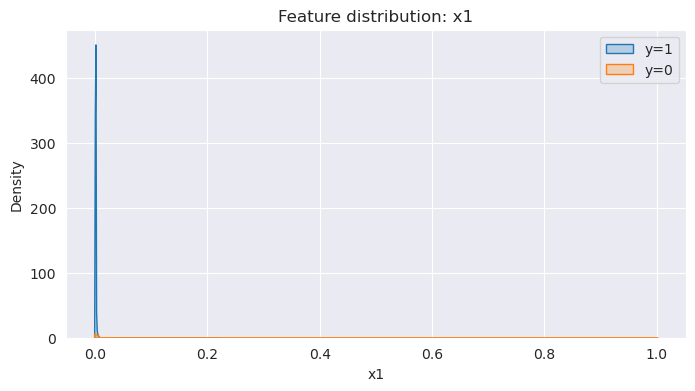

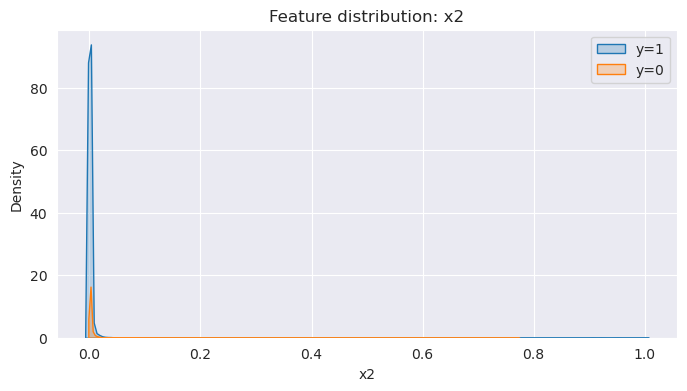

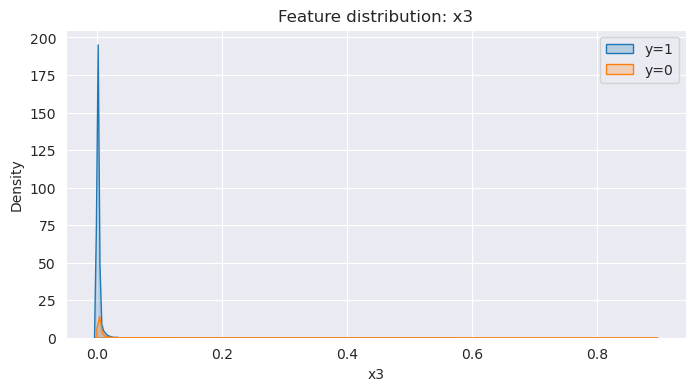

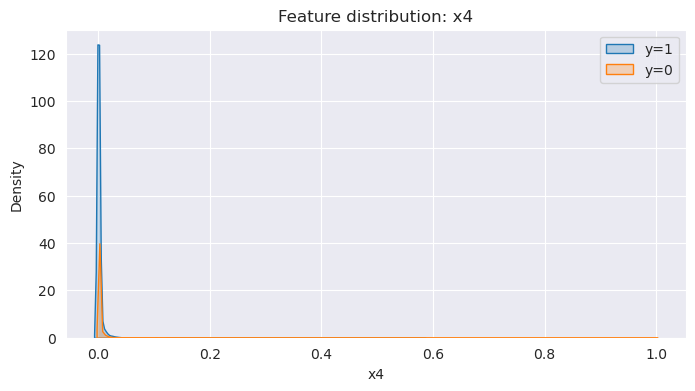

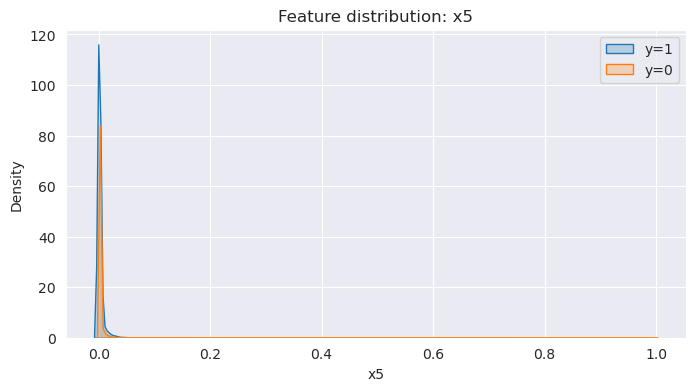

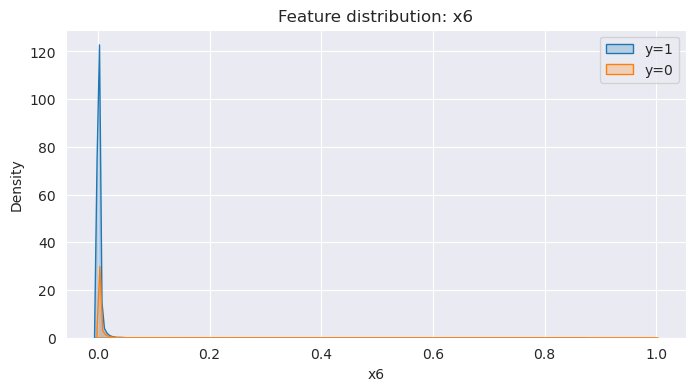

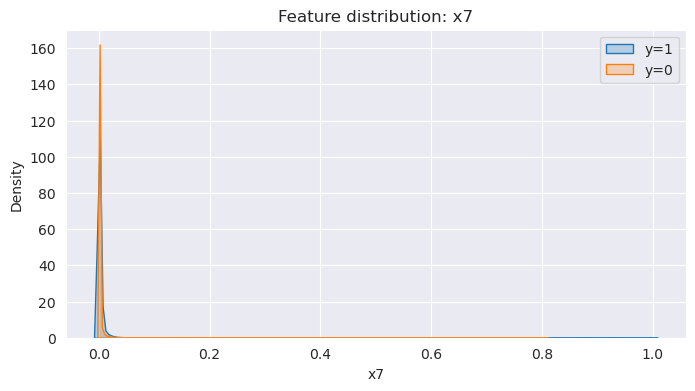

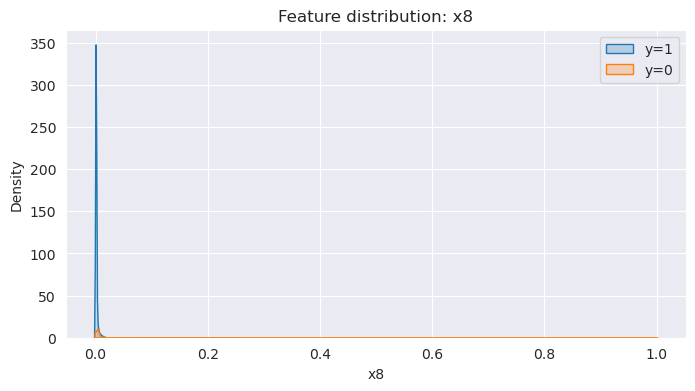

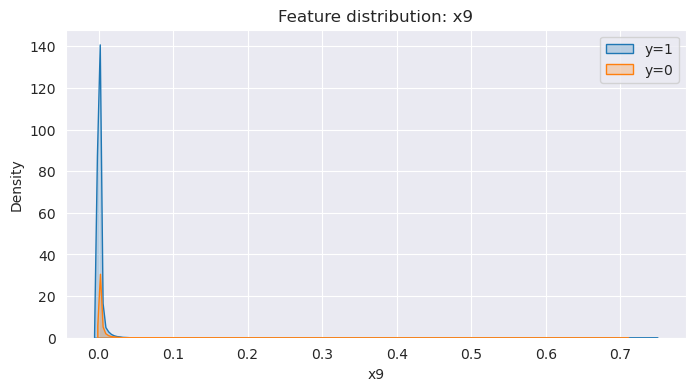

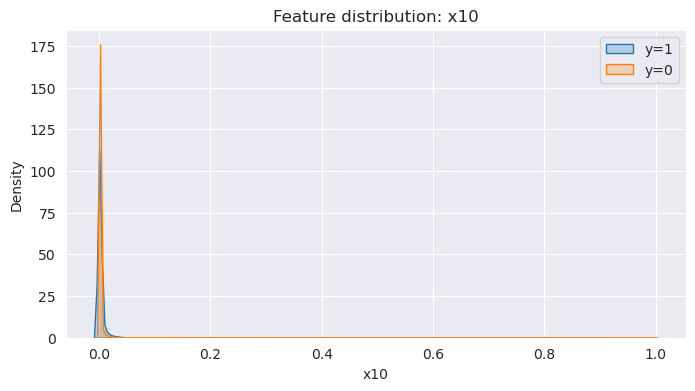

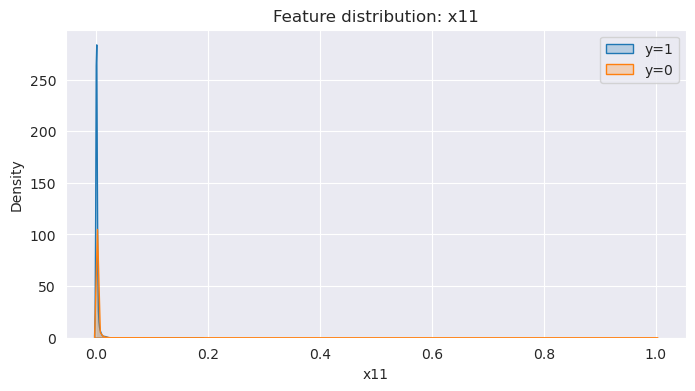

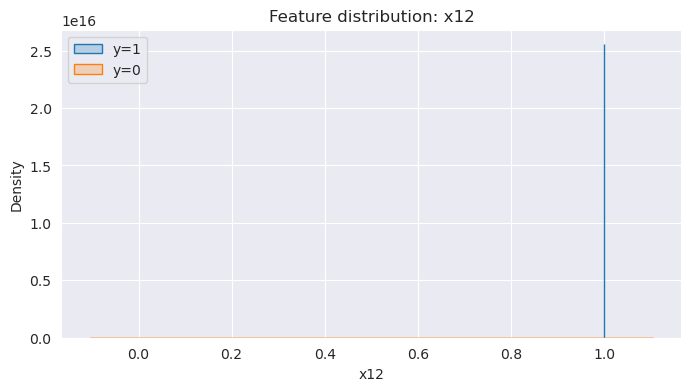

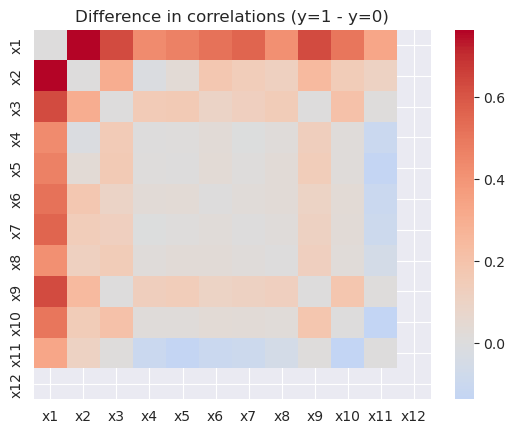

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

for c in x_cols:
    plt.figure(figsize=(8,4))
    sns.kdeplot(temp_pos[c], label="y=1", fill=True)
    sns.kdeplot(temp_neg[c], label="y=0", fill=True)
    plt.title(f"Feature distribution: {c}")
    plt.legend()
    plt.show()

corr_pos = temp_pos[x_cols].corr()
corr_neg = temp_neg[x_cols].corr()

# Можно визуализировать разницу
sns.heatmap(corr_pos - corr_neg, center=0, cmap="coolwarm")
plt.title("Difference in correlations (y=1 - y=0)")
plt.show()

In [8]:
def augment_positive(df, target_col="y", n_copies=5, x_cols=None, max_date=35):
    """
    Аугментация положительных примеров.

    Параметры:
    ----------
    df : pd.DataFrame
        Исходный датафрейм.
    target_col : str
        Название целевой колонки (1 = положительный класс).
    n_copies : int
        Сколько копий генерировать для каждой положительной строки.
    x_cols : list of str
        Список признаков для добавления шума. Если None, берутся все x1-x12.
    max_date : int
        Максимальное значение relative_date_number.

    Возвращает:
    ----------
    df_aug : pd.DataFrame
        Датафрейм с аугментированными положительными примерами.
    """
    if x_cols is None:
        x_cols = [f"x{i}" for i in range(1, 13)]

    pos_df = df[df[target_col] == 1]
    new_rows = []

    for _, row in pos_df.iterrows():
        for _ in range(n_copies):
            new_row = row.copy()

            # шумим числовые признаки, кроме x12
            for c in x_cols:
                if c == "x12":
                    continue
                val = new_row[c]
                noise = np.random.normal(0, val * 0.1)  # 10% шума
                new_row[c] = np.clip(val + noise, 0, 1)

            # x12 почти всегда 1
            new_row["x12"] = 1 if np.random.rand() < 0.95 else 0

            # смещаем дату
            new_row["relative_date_number"] = np.clip(
                new_row["relative_date_number"] + np.random.randint(1, 5),
                1, max_date
            )

            # создаем уникальный id
            new_row["id"] = f"{new_row['g1']};{new_row['g2']};{int(new_row['relative_date_number'])}"

            new_rows.append(new_row)

    df_aug = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
    return df_aug

In [9]:
# -----------------------------
# Копируем данные
# -----------------------------
df = df_train.copy()
df_test = df_test_base.copy()

df["x12"] = (df["x12"] > 0.5).astype(int)
df_test["x12"] = (df_test["x12"] > 0.5).astype(int)

x_cols = [f"x{i}" for i in range(1, 13)]

# -----------------------------
# Генерация признаков (каузально, по g1/g2)
# -----------------------------
df = add_lags(df, x_cols, lags=LAGS)
df = add_diff(df, x_cols, lags=DIFFS)
df = add_rollings(df, x_cols, windows=ROLL_WINDOWS)
df = add_ewm(df, x_cols, alphas=EWMS)
df = add_cumsum(df, x_cols)

df_test = add_lags(df_test, x_cols, lags=LAGS)
df_test = add_diff(df_test, x_cols, lags=DIFFS)
df_test = add_rollings(df_test, x_cols, windows=ROLL_WINDOWS)
df_test = add_ewm(df_test, x_cols, alphas=EWMS)
df_test = add_cumsum(df_test, x_cols)

# -----------------------------
# Генерация дополнительных позитивных примеров
# -----------------------------
df_pos = df[df["y"] == 1].copy()
n_generate = int(len(df_pos) * 2)  # удвоим позитивный класс

df_train_aug = augment_positive(df, n_copies=5)

print("Original size:", len(df))
print("Augmented size:", len(df_train_aug))
# -----------------------------
# Признаки и целевая
# -----------------------------
FEATURES = [c for c in df_train_aug.columns if c not in ["id", "y", "g1", "g2"]]
TARGET = "y"

X = df_train_aug[FEATURES]
y = df_train_aug[TARGET]
X_test = df_test[FEATURES]

# -----------------------------
# scale_pos_weight для CatBoost
# -----------------------------
scale_pos_weight = (y == 0).sum() / (y == 1).sum()
print("scale_pos_weight:", scale_pos_weight)

# -----------------------------
# Holdout по g2 (каталог)
# -----------------------------
unique_g1 = df_train_aug["g1"].unique()
np.random.seed(42)
valid_g1 = np.random.choice(unique_g1, size=int(0.2*len(unique_g1)), replace=False)

train_idx = ~df_train_aug["g1"].isin(valid_g1)
valid_idx = df_train_aug["g1"].isin(valid_g1)

X_train = X.loc[train_idx]
y_train = y.loc[train_idx]
X_valid = X.loc[valid_idx]
y_valid = y.loc[valid_idx]

print("Train pos rate:", y_train.mean())
print("Valid pos rate:", y_valid.mean())

# -----------------------------
# CatBoost модель
# -----------------------------
model = CatBoostClassifier(
    iterations=10000,
    learning_rate=0.03,
    depth=7,
    loss_function="Logloss",
    eval_metric="PRAUC",
    random_seed=42,
    verbose=200,
    l2_leaf_reg=5,
    scale_pos_weight=scale_pos_weight,
    early_stopping_rounds=300
)

model.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    use_best_model=True
)

# -----------------------------
# Validation metrics
# -----------------------------
val_probs = model.predict_proba(X_valid)[:, 1]
thresholds = np.linspace(0.05, 0.6, 50)
f1s = [f1_score(y_valid, val_probs >= t) for t in thresholds]

best_thr = thresholds[np.argmax(f1s)]
best_f1 = max(f1s)
prauc = average_precision_score(y_valid, val_probs)

print(f"PRAUC: {prauc:.4f}")
print(f"Best F1: {best_f1:.4f} @ thr={best_thr:.3f}")

# -----------------------------
# Сохраняем модель
# -----------------------------
model.save_model("catboost_augmented_g2_holdout.cbm")

Original size: 391650
Augmented size: 482500
scale_pos_weight: 3.4257934323977253
Train pos rate: 0.24024459291133507
Valid pos rate: 0.15919158686328652
0:	learn: 0.8600899	test: 0.7948352	best: 0.7948352 (0)	total: 181ms	remaining: 30m 6s
200:	learn: 0.9686584	test: 0.9461913	best: 0.9462066 (199)	total: 29.4s	remaining: 23m 54s
400:	learn: 0.9777035	test: 0.9596385	best: 0.9596385 (400)	total: 58.7s	remaining: 23m 24s
600:	learn: 0.9822554	test: 0.9655432	best: 0.9655432 (600)	total: 1m 28s	remaining: 23m 3s
800:	learn: 0.9850292	test: 0.9679328	best: 0.9679388 (799)	total: 1m 58s	remaining: 22m 41s
1000:	learn: 0.9872274	test: 0.9688829	best: 0.9689168 (985)	total: 2m 30s	remaining: 22m 36s
1200:	learn: 0.9887631	test: 0.9693341	best: 0.9693610 (1192)	total: 3m	remaining: 22m 2s
1400:	learn: 0.9900562	test: 0.9696335	best: 0.9696517 (1399)	total: 3m 30s	remaining: 21m 33s
1600:	learn: 0.9911756	test: 0.9695438	best: 0.9696517 (1399)	total: 4m	remaining: 21m 1s
Stopped by overfittin

In [10]:
test_preds_proba = model.predict_proba(df_test[FEATURES])[:, 1]

# Фиксированный threshold
test_preds_bin = (test_preds_proba >= 0.6).astype(int)

submission = pd.DataFrame({
    "id": df_test["id"],
    "y": test_preds_bin
})

submission.to_csv("submission_f1_all1.csv", index=False)

In [11]:
df = df_train.copy()
df_test = df_test_base.copy()

# Бинаризуем x12
df["x12"] = (df["x12"] > 0.5).astype(int)
df_test["x12"] = (df_test["x12"] > 0.5).astype(int)

x_cols = [f"x{i}" for i in range(1, 13)]

# Генерация признаков (каузально, по g1/g2)
df = add_lags(df, x_cols, lags=LAGS)
df = add_diff(df, x_cols, lags=DIFFS)
df = add_rollings(df, x_cols, windows=ROLL_WINDOWS)
df = add_ewm(df, x_cols, alphas=EWMS)
df = add_cumsum(df, x_cols)

df_test = add_lags(df_test, x_cols, lags=LAGS)
df_test = add_diff(df_test, x_cols, lags=DIFFS)
df_test = add_rollings(df_test, x_cols, windows=ROLL_WINDOWS)
df_test = add_ewm(df_test, x_cols, alphas=EWMS)
df_test = add_cumsum(df_test, x_cols)

In [12]:
# сегменты: 0 = y=0, 1 = y=1
df['cluster_y'] = df['y']

print(df['cluster_y'].value_counts())

cluster_y
0.0    373480
1.0     18170
Name: count, dtype: int64


In [ ]:

# Признаки без target и cluster_y
FEATURES = [c for c in df.columns if c not in ["id", "y", "g1", "g2", "cluster_y"]]

X_seg = df[FEATURES]
y_seg = df['cluster_y']

seg_model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='F1',
    random_seed=42,
    verbose=200,
    early_stopping_rounds=100
)

seg_model.fit(X_seg, y_seg)

0:	learn: 0.0003301	total: 89.9ms	remaining: 2m 59s
200:	learn: 0.0750434	total: 19s	remaining: 2m 49s
400:	learn: 0.1293305	total: 35.7s	remaining: 2m 22s
600:	learn: 0.1684836	total: 1m	remaining: 2m 20s


In [ ]:
# Сегмент y=0
df0 = df[df['cluster_y']==0]
X0, y0 = df0[FEATURES], df0['y']

# Сегмент y=1
df1 = df[df['cluster_y']==1]
X1, y1 = df1[FEATURES], df1['y']

# Рассчитаем scale_pos_weight для редких классов
scale0 = (y0==0).sum() / (y0==1).sum()
scale1 = (y1==0).sum() / (y1==1).sum()

# Модель для сегмента y=0
model0 = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.03,
    depth=7,
    loss_function='Logloss',
    eval_metric='PRAUC',
    scale_pos_weight=scale0,
    random_seed=42,
    verbose=200,
    early_stopping_rounds=300
)
model0.fit(X0, y0)

# Модель для сегмента y=1
model1 = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.03,
    depth=7,
    loss_function='Logloss',
    eval_metric='PRAUC',
    scale_pos_weight=scale1,
    random_seed=42,
    verbose=200,
    early_stopping_rounds=300
)
model1.fit(X1, y1)

In [ ]:
# Предсказываем сегменты
X_test_feats = df_test[FEATURES]
test_seg = seg_model.predict(X_test_feats)

# Создаем массив для предсказаний
test_preds = np.zeros(len(df_test))

# Применяем модель по сегменту
mask0 = (test_seg == 0)
mask1 = (test_seg == 1)

test_preds[mask0] = model0.predict_proba(X_test_feats[mask0])[:, 1]
test_preds[mask1] = model1.predict_proba(X_test_feats[mask1])[:, 1]

In [ ]:
# Создаем holdout (например, последние даты)
holdout_idx = df['relative_date_number'] > 28
X_holdout = df[FEATURES].loc[holdout_idx]
y_holdout = df['y'].loc[holdout_idx]

# Предсказываем сегменты на holdout
holdout_seg = seg_model.predict(X_holdout)

# Создаем массив для holdout-прогнозов
holdout_probs = np.zeros(len(X_holdout))

# Применяем модели по сегменту
mask0 = (holdout_seg == 0)
mask1 = (holdout_seg == 1)

holdout_probs[mask0] = model0.predict_proba(X_holdout[mask0])[:, 1]
holdout_probs[mask1] = model1.predict_proba(X_holdout[mask1])[:, 1]

# Threshold tuning для F1
thresholds = np.linspace(0.05, 0.95, 50)
f1s = [f1_score(y_holdout, holdout_probs >= t) for t in thresholds]

best_thr = thresholds[np.argmax(f1s)]
best_f1 = max(f1s)

# PRAUC
prauc = average_precision_score(y_holdout, holdout_probs)

print(f"PRAUC on holdout: {prauc:.4f}")
print(f"Best F1 on holdout: {best_f1:.4f} @ thr={best_thr:.3f}")

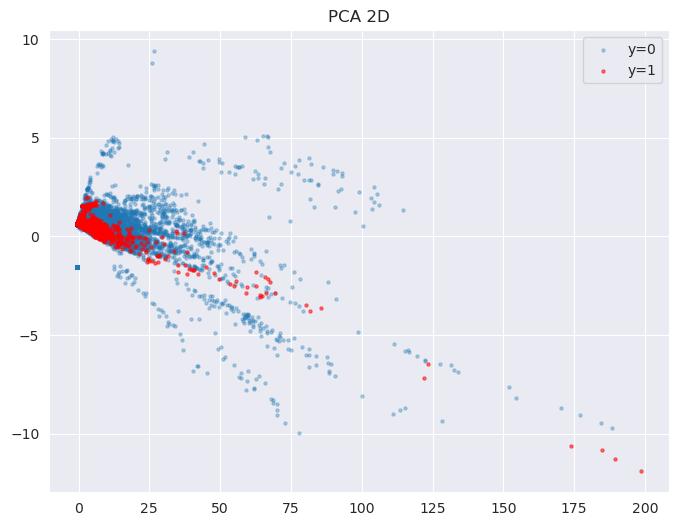

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# допустим, df_train у тебя уже есть
features = [f"x{i}" for i in range(1,13)]
X = df_train[features].values
y = df_train['y'].values

# стандартизируем признаки (важно для PCA/t-SNE/UMAP)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Вариант 1: PCA 2D ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[y==0,0], X_pca[y==0,1], s=5, alpha=0.3, label='y=0')
plt.scatter(X_pca[y==1,0], X_pca[y==1,1], s=5, alpha=0.5, label='y=1', color='red')
plt.title("PCA 2D")
plt.legend()
plt.savefig("pca2d")
plt.show()